### This notebook walks through the building of the CNN, used for binary classification of each individual condition

In [1]:
import os
from os import listdir
import sys
import numpy as np
from numpy import asarray
from numpy import save
import matplotlib.pyplot as plt


import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Input, InputLayer, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint

import random
import shutil

### Sort photos from healthy and conjunctivitis classes into standard directories

In [70]:
# create directories
dataset_home = 'datasets/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['healthy/', 'conjunctivitis/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

In [1]:
# seed random number generator
random.seed(1)
# define ratio of pictures to use for test set
test_ratio = 0.2
# copy training dataset images into subdirectories
src_directory = 'scraping/healthy'
for file in listdir(src_directory):
    print(file)
    src = src_directory + '/' + file
    print(src)
    dst_dir = 'train/'
    if random.random() < test_ratio:
        dst_dir = 'test/'
    dst = dataset_home + dst_dir + 'healthy/'  + file
    print(dst)
    shutil.copyfile(src, dst)

### Next we will develop a Baseline CNN Model

- The baseline model will establish a minimum model performance with which we can compare our subsequent models, and the model architecture will serve as the basis for any improvements
- For the baseline model, we will use a one-block VGG model, which has a single convolutional layer with 32 filters followed by a max pooling layer. (Read more about the VGG model [here](https://arxiv.org/abs/1409.1556))
- The architecture involves stacking convolutional layers with 3x3 filters followed by max pooling layers.  These layers form a "block," which can be repeated with the number of filters increasing with the depth of the network.  Padding is applied on the convolutional layers to ensure height/width of the output feature maps matches the inputs

In [2]:
# define cnn model
def one_block_vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

We will also define two-block and three-block VGG models to compare to the baseline model.  Each additional block increases the capacity and complexity of the model, which can help achieve better results but also increases the risk of overfitting

In [3]:
def two_block_vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# define cnn model
def three_block_vgg():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [61]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 10))
    ax1.set_title('Cross Entropy Loss')
    ax1.plot(history.history['loss'], color = 'blue', label='train')
    ax1.plot(history.history['val_loss'], color = 'orange', label='test')
    ax1.set_ylim(0,2)

    ax2.set_title('Classification Accuracy')
    ax2.plot(history.history['accuracy'], color='blue', label='train')
    ax2.plot(history.history['val_accuracy'], color='orange', label='test')

    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    
    plt.savefig(filename + '_plot.png')
    plt.close()

In [7]:
# function to train train and evaluate each model
def run_model(option=1):
    # define model
    if option == 1:
        model = one_block_vgg()
    elif option == 2:
        model = two_block_vgg()
    elif option == 3:
        model = three_block_vgg()
    elif option == 4:
        model = vgg3_with_dropout()

    # create data generator
    # apply data augmentation 
    datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_it = datagen.flow_from_directory(
        'datasets/train/',
        target_size=(200, 200),
        batch_size=32,
        class_mode='binary')

    test_it = datagen.flow_from_directory(
        'datasets/test/',
        target_size=(200, 200),
        batch_size=32,
        class_mode='binary')

    checkpoint_filepath = 'checkpoint/'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
    
    #include callback to save model weights whenever the model achieves a new best validation accuracy
    filepath="tmp/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        verbose=1, 
        save_best_only=True, 
        mode='max')
    callbacks_list = [checkpoint]

    history = model.fit_generator(
        train_it,
        steps_per_epoch=len(train_it),
        validation_data=test_it,
        validation_steps=len(test_it),
        epochs=5,
        callbacks=callbacks_list,
        verbose=2)
    
    # learning curves
    summarize_diagnostics(history)
    
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    

In [77]:
#plot to create stylized diagnostic plot for presentation
def accuracy_plot(history, filename):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_title('Classification Accuracy - VGG3 With Augmentation + Dropout', fontweight='bold', fontsize=20, loc='left')
    ax.plot(history.history['accuracy'], color='#696c70', label='train', linewidth=2.5)
    ax.plot(history.history['val_accuracy'], color='#397ad4', label='test', linewidth=2.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Training Epoch', fontsize=15)
    
    #include annotations, manually cut/paste them into ideal locations 
    ax.annotate('Accuracy', [1,0.5], [80, 0.60], fontsize=14, annotation_clip=False)
    ax.annotate('Train', [1,0.5], [40, 0.60], fontsize=14, annotation_clip=False, color='#696c70', fontweight='bold')
    ax.annotate('Validation', [1,0.5], [50, 0.60], fontsize=14, annotation_clip=False, color='#397ad4', fontweight='bold')
    
    plt.savefig(filename + '_plot.png')
    plt.close()

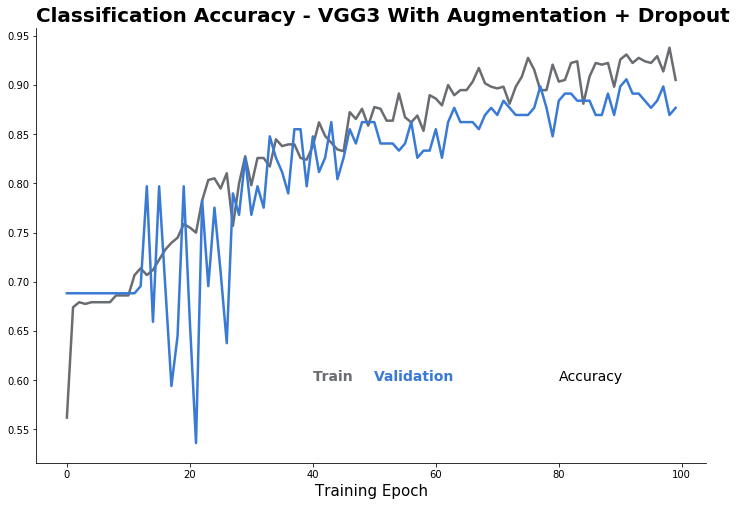

In [78]:
accuracy_plot(history)

VGG1 with data augmentation:

In [20]:
# run_test_harness(option=1)

VGG2 with data augmentation:

In [2]:
# run_test_harness(option=2)

VGG3 with data augmentation:

In [3]:
# run_test_harness(option=3)

### Model Improvements

- We see a trend of improved performance, but also see overfitting occurring earlier and earlier in the run
- First we will introduce dropout regularization, which works by probabilistically "dropping out" inputs to a layer, which has the effect of simulating a large number of networks with different network structures.  

In [80]:
def vgg3_with_dropout():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    opt=SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

VGG3 with data augmentation and dropout layers:

In [17]:
# run_test_harness(option=4)

### Transfer learning
- Next, we will try a transfer learning model, which means taking the convolutional base of a pre-trained network in order to develop features that generalize well to a broad set of computer vision problems
- The VGG 16 model is a popular model trained on ImageNet, which contains over 15 million high-res images

This technique gets our model's validation accuracy up to **94.3%**

In [6]:
def save_bottleneck_features():
    model = VGG16(
        include_top = False,
        input_shape = (224, 224, 3)
    )

    datagen = ImageDataGenerator(featurewise_center=True)
    datagen.mean = [123.68, 116.779, 103.939]

    generator = datagen.flow_from_directory(
        'datasets/train',
        target_size=(224, 224),
        batch_size=20,
        class_mode=None,
        shuffle=False
    )
    
    
    bottleneck_features_train = model.predict_generator(generator, 580 // 20)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        'datasets/test',
        target_size=(224, 224),
        batch_size=23,
        class_mode=None,
        shuffle=False
    )

    bottleneck_features_validation = model.predict_generator(generator, 138 // 23)
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [97]:
def train_top_model():
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    print(train_data.shape)
    train_labels = np.array([0]*(290) + [1]*(290))
    print(train_labels.shape)
    
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0]*(69) + [1]*(69))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    checkpoint_filepath = 'checkpoint_pink/weights-{epoch:02d}-{val_accuracy:.3f}.hdf5'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    history = model.fit(train_data, train_labels,
             epochs=200,
             batch_size=32,
             callbacks=[model_checkpoint_callback],
             validation_data=(validation_data, validation_labels))
    model.save_weights('bottleneck_fully_connected_model.h5')
    
    
        
    

    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    accuracy_plot(history)


In [7]:
# save_bottleneck_features()

(580, 7, 7, 512)
(580,)
Epoch 1/200
16/19 [========================>.....] - ETA: 0s - loss: 9.0826 - accuracy: 0.5859
Epoch 00001: val_accuracy improved from -inf to 0.31159, saving model to checkpoint_pink/weights-01-0.312.hdf5
19/19 [==============================] - 1s 34ms/step - loss: 9.3640 - accuracy: 0.5862 - val_loss: 8.1862 - val_accuracy: 0.3116
Epoch 2/200
18/19 [===========================>..] - ETA: 0s - loss: 8.4357 - accuracy: 0.5799
Epoch 00002: val_accuracy improved from 0.31159 to 0.70290, saving model to checkpoint_pink/weights-02-0.703.hdf5
19/19 [==============================] - 1s 30ms/step - loss: 8.4049 - accuracy: 0.5793 - val_loss: 0.6493 - val_accuracy: 0.7029
Epoch 3/200
16/19 [========================>.....] - ETA: 0s - loss: 1.7202 - accuracy: 0.6328
Epoch 00003: val_accuracy did not improve from 0.70290
19/19 [==============================] - 0s 24ms/step - loss: 1.7137 - accuracy: 0.6224 - val_loss: 0.8032 - val_accuracy: 0.3188
Epoch 4/200
18/19 [==

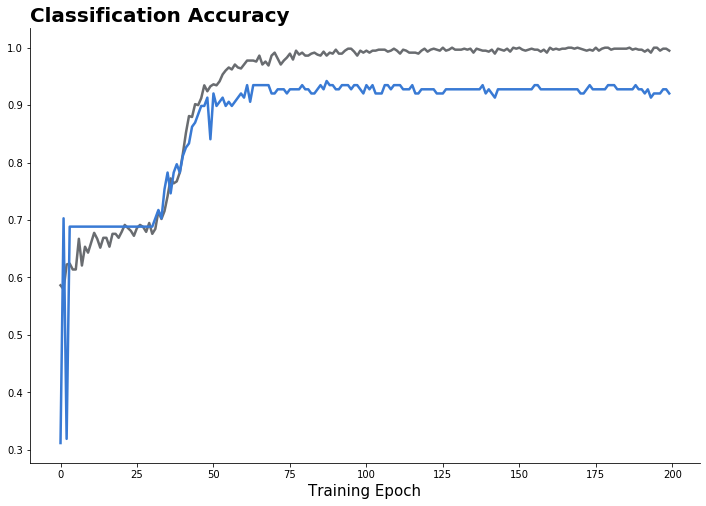

In [100]:
train_top_model()

### Fine-tuning the top layer of the pre-trained network

Using the VGG16 model gives us a great result, but we can further fine-tune the model by altering the last convolutional block of the VGG16 model which was previously frozen to training.  Since the features learned by low-level convolutional blocks are more general, and those found higher up are more specialized features, it is sensible to keep the first few block fixed and only fine-tune the last one.  We do this by:
- Instantiating the convolutional base of VGG16
- Adding our previously defined fully-connected model on top (with the properly trained weights, NOT just a randomly initialized fully-connected network.  Randomly initialized weights could trigger large gradient updates that would wreck the learned weights in the convolutional base.  We're aiming to just incrementally fine-tune the convolutional layer.
- Freezing the layers of the VGG16 model up to the last convolutional block

In [167]:
def run_transfer_learning_fine_tune():
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    print(vgg_model.output_shape[1:])
    print('Model loaded')
    
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.3))
    top_model.add(Dense(128, activation='relu'))
    top_model.add(Dropout(0.65))
    top_model.add(Dense(64, activation='relu'))
    top_model.add(Dropout(0.15))
    top_model.add(Dense(1, activation='sigmoid'))


    top_model.load_weights('checkpoint/weights-57-0.928.hdf5')

    model=Sequential()
    model.add(vgg_model)
    model.add(top_model)

    #Set layers up to last conv. block to be non-trainable
    for layer in model.layers[:25]:
        layer.trainable = False

    #Set small learning rate to make sure magnitude of updates stays small
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(featurewise_center=True)
    datagen.mean = [123.68, 116.779, 103.939]

    # test_datagen = ImageDataGenerator(rescale=1./255)

    train_it = datagen.flow_from_directory('datasets/train/',
                                                 target_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode='binary')
    test_it = datagen.flow_from_directory('datasets/test/',
                                               target_size=(224, 224),
                                               batch_size=16,
                                               class_mode='binary')

    history = model.fit_generator(train_it,
                                  steps_per_epoch=len(train_it),
                                  validation_data=test_it,
                                  validation_steps=len(test_it),
                                  epochs=50,
                                  verbose=1)

    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))

    # learning curves
    summarize_diagnostics(history)

In [8]:
# run_transfer_learning_fine_tune()

### Get Predictions

I created the module generate_predictions which will allow for quick predictions on an an input image. 

In [1]:
from generate_prediction import Predictions

In [2]:
x = Predictions()
x

Conjunctivitis - consider seeing a medical professional


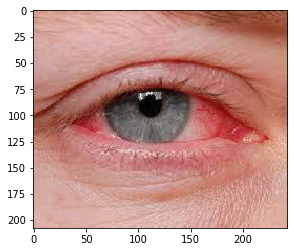

0.026475906

In [3]:
#choose test_image
filepath = 'datasets3/test/conjunctivitis/'
filename = 'pink eye.jpg'

x.predict(filepath + filename)

In [4]:
x.model

In [8]:
x.image.shape

(1, 224, 224, 3)

In [11]:
#0 = conjunctivitis
#1 = healthy
x.prediction

0.026475906

In [12]:
x.image_features.shape

(1, 7, 7, 512)